In [1]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

In [2]:
service_account = 'service-account@iron-dynamics-294100.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

In [12]:
sitename = "bucklands_beach"
bbox = gpd.read_file("~/CoastSeg/bbox.geojson").geometry[0]
list(bbox.exterior.coords)

[(174.908438, -36.879895),
 (174.908438, -36.86709),
 (174.922771, -36.86709),
 (174.922771, -36.879895),
 (174.908438, -36.879895)]

In [16]:
inputs = {
    "polygon": list(bbox.exterior.coords),# list(poly.geometry[sitename].exterior.coords),
    "dates": ['1900-01-01', '2030-12-30'], # All available imagery
    "sat_list": ['L5','L7','L8','L9'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
result = SDS_download.check_images_available(inputs)

Number of images available between 1900-01-01 and 2030-12-30:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 212 images
     L7: 1255 images
     L8: 657 images
     L9: 157 images
L5:There are 212 images available, 140 images already exist, 72 to download
L7:There are 1255 images available, 0 images already exist, 1255 to download
L8:There are 657 images available, 0 images already exist, 657 to download
L9:There are 157 images available, 0 images already exist, 157 to download
  Total images available to download from Tier 1: 2141 images
  Total images available to download from Tier 2: 0 images


In [15]:
metadata = SDS_download.retrieve_images(inputs)
#metadata = SDS_download.get_metadata(inputs)

Number of images available between 1900-01-01 and 2030-12-30:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 212 images
     L7: 1255 images
     L8: 657 images
     L9: 157 images
L5:There are 212 images available, 140 images already exist, 72 to download
L7:There are 1255 images available, 0 images already exist, 1255 to download
L8:There are 657 images available, 0 images already exist, 657 to download
L9:There are 157 images available, 0 images already exist, 157 to download
  Total images available to download from Tier 1: 2141 images
  Total images available to download from Tier 2: 0 images


bucklands_beach: Downloading Imagery for 4 satellites:   0%|          | 0/4 [00:00<?, ?it/s]

bucklands_beach: Downloading Imagery for L5:   0%|          | 0/72 [00:00<?, ?it/s]

skipping image '2003-09-23-21-43-39_L5_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2003-11-26-21-44-30_L5_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2004-05-04-21-46-16_L5_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2004-06-05-21-47-12_L5_bucklands_beach_ms.tif' due to cloud and no data cover 98.51% exceeds threshold of 95.00%
skipping image '2004-08-08-21-48-50_L5_bucklands_beach_ms.tif' due to cloud and no data cover 98.85% exceeds threshold of 95.00%
skipping image '2004-10-11-21-50-27_L5_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2004-11-12-21-51-03_L5_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2005-01-31-21-52-21_L5_bucklands_beach_ms.tif' due to cloud and no data cove

bucklands_beach: Downloading Imagery for L7:   0%|          | 0/1255 [00:00<?, ?it/s]

skipping image '1999-10-06-21-59-04_L7_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '1999-10-22-21-58-52_L7_bucklands_beach_ms.tif' due to cloud and no data cover 96.44% exceeds threshold of 95.00%
skipping image '1999-11-07-21-58-56_L7_bucklands_beach_ms.tif' due to cloud and no data cover 95.22% exceeds threshold of 95.00%
skipping image '1999-11-23-21-58-47_L7_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '1999-12-25-21-58-52_L7_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2000-01-26-21-58-50_L7_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2000-02-27-21-58-40_L7_bucklands_beach_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2000-04-15-21-58-19_L7_bucklands_beach_ms.tif' due to cloud and no data cove

In [8]:
shorelines = gpd.read_file("shorelines.geojson")
#shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

,area,beach_length,easting,name,northing,Tide range,median_orientation,id_sorted,same_beach,median_slope,ci,n_points,n_points_nonan,geometry
id,,,,,,,,,,,,,,
aus0001,14472901.48412414,16824.52342226356,526589.1754011525,noname,7259734.061377056,1.451,92.466545,aus0001,None,0.076702,0.0214,654.0,520.0,"LINESTRING (153.26746 -24.70115, 153.26743 -24..."
aus0002,53438721.70867591,16794.63203331262,529484.7418874454,noname,7243833.021796449,1.073,64.603602,aus0002,1,0.059681,0.0203,579.0,407.0,"LINESTRING (153.26189 -24.85277, 153.26191 -24..."
aus0003,945965.0455573548,1373.06418305453,535380.0262458471,noname,7237842.578773651,1.074,93.116374,aus0003,None,0.041382,0.0112,335.0,243.0,"LINESTRING (153.35089 -24.96818, 153.35075 -24..."
aus0004,376936.0048626679,253.8720097247056,535397.4773649719,noname,7236435.680204276,1.074,79.203813,aus0004,None,0.051540,0.0154,319.0,238.0,"LINESTRING (153.35051 -24.98595, 153.35099 -24..."
aus0005,1570125.540326883,1830.166677525537,535675.2172291321,noname,7235101.123683789,1.074,74.946714,aus0005,None,0.054151,0.0245,307.0,231.5,"LINESTRING (153.35161 -24.99115, 153.35228 -24..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0317,998611.0209522904,1388.636895098391,-4971829.852334809,noname,-4971829.852334809,NaN,309.396745,nzd0556,None,0.051980,0.0053,397.0,301.0,"LINESTRING (172.31541 -40.72839, 172.31783 -40..."
nzd0316,4300057.774234623,4647.035750366853,-4966165.280134064,noname,-4966165.280134064,NaN,304.531268,nzd0557,None,0.057371,0.0078,363.0,266.0,"LINESTRING (172.36751 -40.69864, 172.3702 -40...."
nzd0313,22919741.04033367,17378.17283613481,19237414.32246552,noname,-4939929.050573792,NaN,6.636156,nzd0558,None,0.026684,0.0057,324.0,125.0,"LINESTRING (172.73493 -40.50746, 172.73502 -40..."


In [9]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 2193,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [10]:
transects_gdf = gpd.read_file("transects_extended.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,r2_score,mae,mse,rmse,intercept,geometry
id,,,,,,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,0.085285,617.0,460.0,0.002280,10.369049,167.457036,12.940519,359.114853,"LINESTRING (175.85292 -36.99002, 175.86148 -36..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.019487,617.0,452.0,0.000147,9.209802,134.835800,11.611882,355.566495,"LINESTRING (175.85341 -36.99062, 175.86196 -36..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.117671,617.0,452.0,0.006428,8.662931,113.267502,10.642721,353.718318,"LINESTRING (175.8539 -36.99122, 175.86245 -36...."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.142979,617.0,461.0,0.011425,7.681668,92.949856,9.641051,353.638180,"LINESTRING (175.85442 -36.99186, 175.86289 -36..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.120310,617.0,467.0,0.009250,7.080162,81.416416,9.023105,352.931898,"LINESTRING (175.85496 -36.99249, 175.86335 -36..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.086616,617.0,469.0,0.004732,7.249153,83.752495,9.151639,353.800086,"LINESTRING (175.85547 -36.99308, 175.86386 -36..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,0.014343,617.0,477.0,0.000116,7.576872,93.530888,9.671137,354.967633,"LINESTRING (175.85602 -36.99371, 175.86431 -36..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.041507,617.0,470.0,0.001077,7.219020,83.940709,9.161916,353.078306,"LINESTRING (175.85662 -36.99436, 175.86473 -36..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,0.008404,617.0,475.0,0.000040,7.498900,93.589266,9.674155,350.936056,"LINESTRING (175.8572 -36.99497, 175.86523 -36...."


{'nzd0188-0000': array([[1853903.79173159, 5902429.82995296],
        [1854681.05294535, 5902921.11282454]]),
 'nzd0188-0001': array([[1853945.26044723, 5902361.69508307],
        [1854722.52049202, 5902852.97518748]]),
 'nzd0188-0002': array([[1853986.85848043, 5902293.35435046],
        [1854763.78357965, 5902785.15776651]]),
 'nzd0188-0003': array([[1854031.20695316, 5902220.92773169],
        [1854800.9708178 , 5902723.82805059]]),
 'nzd0188-0004': array([[1854077.33844014, 5902149.90139114],
        [1854840.13111651, 5902663.2781724 ]]),
 'nzd0188-0005': array([[1854120.75363114, 5902082.98203419],
        [1854883.54530015, 5902596.35598587]]),
 'nzd0188-0006': array([[1854167.22040533, 5902011.58822146],
        [1854922.17765126, 5902536.37689238]]),
 'nzd0188-0007': array([[1854218.63417685, 5901937.61543954],
        [1854958.16033193, 5902483.86703644]]),
 'nzd0188-0008': array([[1854268.78420989, 5901869.34967332],
        [1855000.75205605, 5902425.65454438]]),
 'nzd0188-

In [11]:
ref_sl = np.array(line_merge(split(shorelines.geometry.to_crs(settings["output_epsg"])[sitename], transects_gdf.to_crs(settings["output_epsg"]).unary_union)).coords)
ref_sl

array([[1854208.48953144, 5902621.1073155 ],
       [1854249.38022094, 5902553.91903075],
       [1854290.84754181, 5902485.78327183],
       [1854330.93567873, 5902419.91367679],
       [1854332.3790657 , 5902417.68878842],
       [1854375.79341193, 5902350.76836   ],
       [1854419.20791121, 5902283.84769565],
       [1854462.62146095, 5902216.92849497],
       [1854483.89360139, 5902184.1388557 ],
       [1854507.96804262, 5902151.33213519],
       [1854555.17121176, 5902087.00743655],
       [1854602.37538915, 5902022.68136393],
       [1854605.15326347, 5902018.89589927],
       [1854643.21655382, 5901954.20018567],
       [1854683.65545737, 5901885.46667108],
       [1854695.21790303, 5901865.81412223],
       [1854730.91462645, 5901821.39592   ],
       [1854780.90172801, 5901759.19589228],
       [1854819.05800872, 5901711.71720992],
       [1854832.8882584 , 5901698.84277235],
       [1854873.87099709, 5901660.69236125]])

In [12]:
settings["max_dist_ref"] = 300
settings["reference_shoreline"] = ref_sl #np.flip(ref_sl)

In [13]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L5:   100%
L7:   100%
L8:   4%Could not map shoreline for this image: 2013-10-29-22-01-34_L8_072086_nzd0188_ms.tif
L8:   67%Could not map shoreline for this image: 2021-02-05-21-59-58_L8_072086_nzd0188_ms.tif
L8:   67%Could not map shoreline for this image: 2021-02-21-21-59-53_L8_072086_nzd0188_ms.tif
L8:   70%Could not map shoreline for this image: 2021-06-20-22-05-29_L8_073085_nzd0188_ms.tif
L8:   79%Could not map shoreline for this image: 2022-06-07-22-05-43_L8_073085_nzd0188_ms.tif
L8:   83%Could not map shoreline for this image: 2022-09-27-22-06-16_L8_073085_nzd0188_ms.tif
L8:   100%
L9:   31%Could not map shoreline for this image: 2022-10-21-22-06-05_L9_073085_nzd0188_ms.tif
L9:   69%Could not map shoreline for this image: 2023-11-25-22-05-56_L9_073085_nzd0188_ms.tif
L9:   80%Could not map shoreline for this image: 2024-02-13-22-05-53_L9_073085_nzd0188_ms.tif
L9:   100%


In [23]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [14]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

12 duplicates
1 bad georef


In [15]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

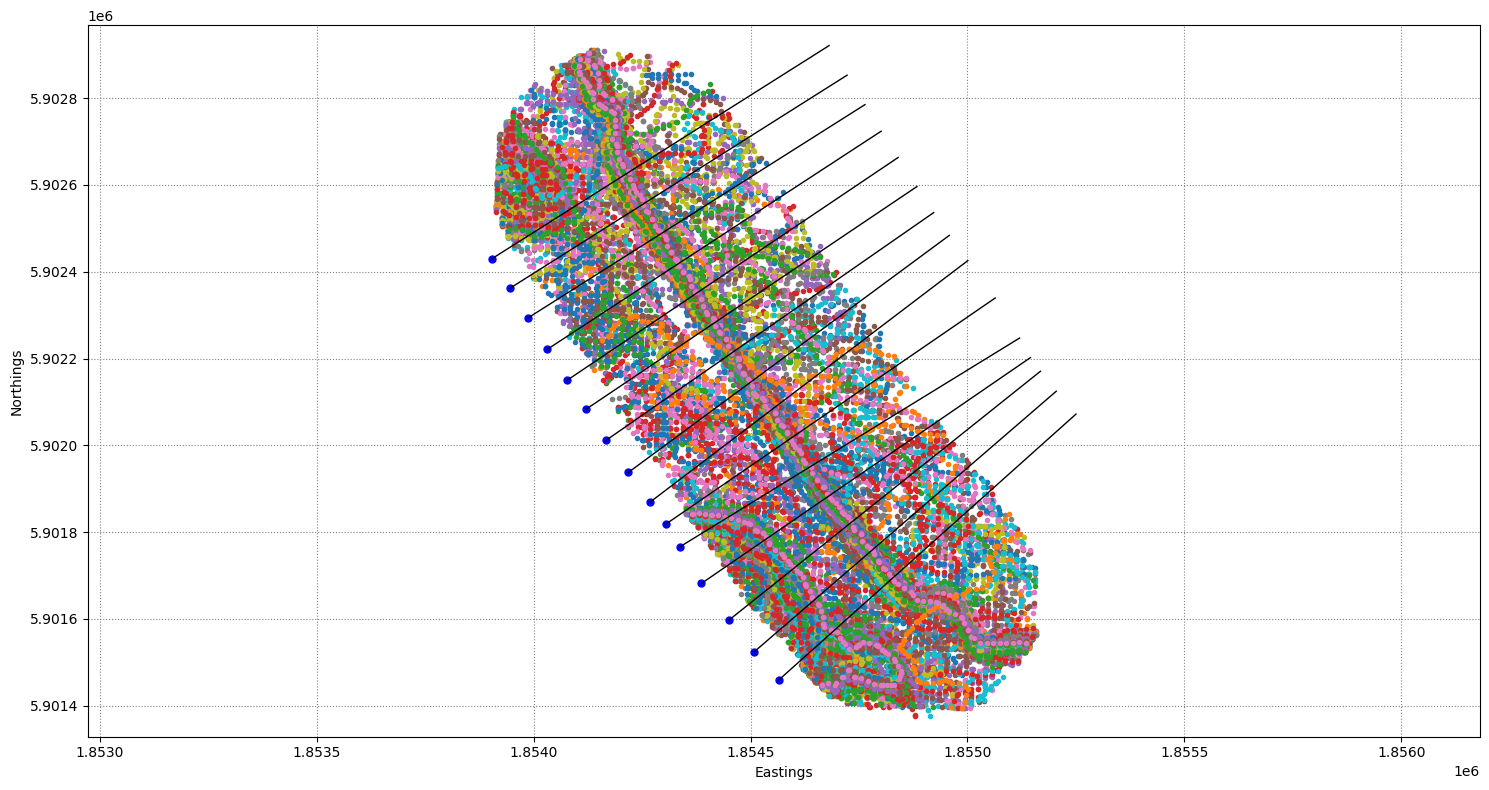

In [16]:
plt.ioff()
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'),lw=.1)
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    #plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-0", ""),
    #            va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [17]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

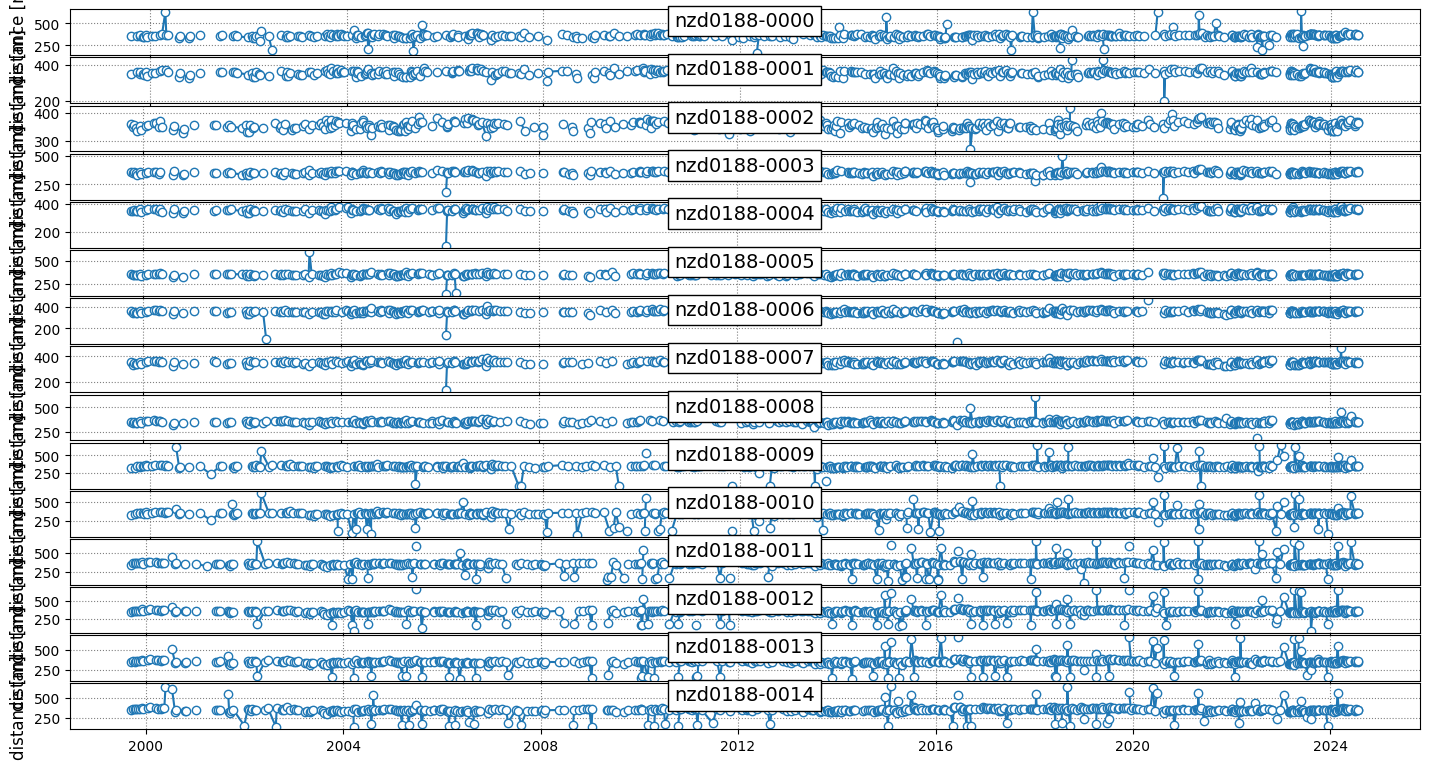

In [18]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
plt.show()

In [19]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
#df.to_csv(fn, sep=',')
#print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

,dates,satname,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
0,1999-08-12 21:52:44+00:00,L7,357.303534,351.762660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326.584962,327.280736,NaN,NaN,NaN,NaN
1,1999-09-13 21:52:41+00:00,L7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.720577,341.278142,346.590199,341.590973,352.016633,351.214334
2,1999-09-29 21:52:52+00:00,L7,360.836612,360.166068,360.307052,355.338663,350.225359,353.457342,354.759349,354.151751,354.220717,356.130659,360.722365,368.649003,360.629868,366.172258,359.719680
3,1999-10-15 21:52:49+00:00,L7,357.245295,350.406320,350.044970,348.368491,343.998205,345.696102,343.817475,333.636900,341.358176,336.483830,352.467928,364.555400,363.076837,356.964474,360.039780
4,1999-10-22 21:58:52+00:00,L7,369.232442,360.075930,356.248311,357.381505,356.702827,352.507429,352.513526,346.875717,344.771217,345.504402,359.264475,373.896467,365.337652,365.098532,365.482892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2024-06-28 22:05:19+00:00,L8,364.608289,NaN,352.124047,NaN,NaN,348.225223,352.071569,346.261806,344.518192,343.991508,344.125329,348.081497,353.513092,347.968535,343.420999
723,2024-06-29 21:58:59+00:00,L9,376.601643,363.078641,361.032636,362.495472,362.905810,362.217878,357.656604,359.291593,354.681435,357.867932,357.337638,359.337106,362.578791,360.239910,350.112450
724,2024-07-07 21:59:13+00:00,L8,378.030161,369.241113,367.288186,362.767466,362.459045,359.054226,356.590321,356.582954,354.308610,352.132798,356.805214,365.543201,364.787017,364.381581,362.854130
725,2024-07-22 22:05:28+00:00,L9,369.992897,361.274516,366.308501,365.414053,354.901456,357.794904,360.555327,354.714581,344.697336,352.053574,355.721737,360.584779,362.108647,357.861604,356.486811


In [20]:
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)

In [21]:
prev = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
prev.set_index("dates", inplace=True)
prev.index = pd.to_datetime(prev.index)
prev

,satname,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
dates,,,,,,,,,,,,,,,,
1999-09-13 21:52:41+00:00,L7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.11,342.41,347.92,342.98,353.17,351.31
1999-09-29 21:52:52+00:00,L7,361.10,360.43,360.43,355.66,350.35,353.71,354.91,354.22,354.41,356.31,360.87,368.93,360.76,366.32,360.02
1999-10-15 21:52:49+00:00,L7,356.55,349.87,349.57,347.86,344.41,345.36,343.49,333.21,340.86,336.70,351.90,363.91,362.34,356.28,359.36
1999-10-22 21:58:52+00:00,L7,370.92,361.03,358.30,358.05,357.17,352.84,353.05,347.67,345.31,346.15,359.73,374.67,365.95,365.73,366.15
1999-11-07 21:58:56+00:00,L7,350.66,348.23,345.48,348.03,346.08,345.58,342.81,342.57,341.76,344.18,351.38,366.03,362.72,365.56,364.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28 21:59:12+00:00,L9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395.29,395.48,547.28,623.33,NaN,NaN,655.75
2024-06-29 21:58:59+00:00,L9,377.02,363.58,361.57,363.39,363.19,363.95,358.62,359.84,356.24,358.86,358.41,359.87,363.37,359.49,348.14
2024-07-07 21:59:13+00:00,L8,378.21,369.48,367.69,363.02,362.56,359.20,356.75,356.83,354.49,352.42,356.94,365.74,364.98,364.55,363.08


In [25]:
(df.drop(columns="satname")-prev.drop(columns="satname")).mean()

nzd0188-0000   -0.091116
nzd0188-0001   -0.043623
nzd0188-0002   -0.049835
nzd0188-0003   -0.027537
nzd0188-0004   -0.005873
nzd0188-0005   -0.048840
nzd0188-0006   -0.022342
nzd0188-0007   -0.083212
nzd0188-0008    0.056931
nzd0188-0009    0.547146
nzd0188-0010    0.031298
nzd0188-0011    0.504352
nzd0188-0012    0.997233
nzd0188-0013    2.213869
nzd0188-0014    1.667043
dtype: float64

In [69]:
df.shape, vos.shape

((712, 16), (538, 15))

In [70]:
transects_gdf.to_crs(settings["output_epsg"], inplace=True)
transects_gdf

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.012672,538.0,378.0,"LINESTRING (19576062.908 -4437572.721, 1957639..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.013116,538.0,398.0,"LINESTRING (19576117.273 -4437656.653, 1957645..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.171418,538.0,397.0,"LINESTRING (19576171.711 -4437740.698, 1957650..."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.250361,538.0,402.0,"LINESTRING (19576227.77 -4437826.954, 19576560..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.122757,538.0,413.0,"LINESTRING (19576286.064 -4437911.554, 1957661..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.180411,538.0,407.0,"LINESTRING (19576342.818 -4437993.888, 1957667..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.051175,538.0,406.0,"LINESTRING (19576401.302 -4438078.691, 1957672..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.057596,538.0,403.0,"LINESTRING (19576463.891 -4438163.882, 1957678..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.109327,538.0,397.0,"LINESTRING (19576526.951 -4438244.99, 19576842..."


In [71]:
#df = pd.read_csv("data/nzd0188/transect_time_series.csv")
#df.drop(columns="Unnamed: 0", inplace=True)
#df.set_index("dates", inplace=True)
my_intersects = df.loc["2003-07-21 21:42:33+00:00"]
my_intersects

satname                 L5
nzd0188-0000     201.41361
nzd0188-0001    204.290092
nzd0188-0002    195.089171
nzd0188-0003     191.85769
nzd0188-0004    190.040593
nzd0188-0005    189.585028
nzd0188-0006    188.806124
nzd0188-0007     195.67555
nzd0188-0008    196.019977
nzd0188-0009     193.64007
nzd0188-0010    185.537321
nzd0188-0011    190.681022
nzd0188-0012    193.601484
nzd0188-0013    186.046824
nzd0188-0014      191.5192
Name: 2003-07-21 21:42:33+00:00, dtype: object

In [72]:
vos_intersects = vos.loc["2003-07-21 21:42:33+00:00"]
vos_intersects

nzd0188-0000    207.039370
nzd0188-0001    197.955344
nzd0188-0002    194.805314
nzd0188-0003    186.587322
nzd0188-0004    185.022602
nzd0188-0005    183.966109
nzd0188-0006    180.446069
nzd0188-0007    181.399493
nzd0188-0008    190.490556
nzd0188-0009    184.743819
nzd0188-0010    183.521960
nzd0188-0011    184.156911
nzd0188-0012    181.139068
nzd0188-0013    178.159517
nzd0188-0014    173.881791
Name: 2003-07-21 21:42:33+00:00, dtype: float64

In [73]:
(my_intersects - vos_intersects).mean()

6.699234170633337

In [74]:
from shapely import line_interpolate_point
my_intersect_points = gpd.GeoSeries(transects_gdf.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], my_intersects[transect_id])), crs=transects_gdf.crs)
vos_intersect_points = gpd.GeoSeries(vos_intersects.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], vos_intersects[transect_id])), crs=transects_gdf.crs)
my_intersect_points, vos_intersect_points

(id
 nzd0188-0000    POINT (19576231.957 -4437463.223)
 nzd0188-0001    POINT (19576288.736 -4437545.591)
 nzd0188-0002     POINT (19576335.38 -4437634.527)
 nzd0188-0003     POINT (19576387.211 -4437720.24)
 nzd0188-0004    POINT (19576442.532 -4437803.697)
 nzd0188-0005     POINT (19576498.912 -4437886.29)
 nzd0188-0006    POINT (19576555.122 -4437969.204)
 nzd0188-0007    POINT (19576619.977 -4438045.874)
 nzd0188-0008    POINT (19576681.679 -4438124.645)
 nzd0188-0009    POINT (19576741.012 -4438204.795)
 nzd0188-0010    POINT (19576787.464 -4438293.315)
 nzd0188-0011     POINT (19576845.19 -4438375.693)
 nzd0188-0012     POINT (19576909.48 -4438452.878)
 nzd0188-0013     POINT (19576968.77 -4438534.226)
 nzd0188-0014    POINT (19577040.349 -4438604.352)
 Name: id, dtype: geometry,
 nzd0188-0000    POINT (19576236.679 -4437460.165)
 nzd0188-0001    POINT (19576283.419 -4437549.035)
 nzd0188-0002    POINT (19576335.142 -4437634.682)
 nzd0188-0003    POINT (19576382.831 -4437723.171)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -inf, 'width': 88, 'height': 102, 'count': 5, 'crs': CRS.from_epsg(32660), 'transform': Affine(15.0, 0.0, 397905.0,
       0.0, -15.0, -4093875.0)}
(5, 102, 88)


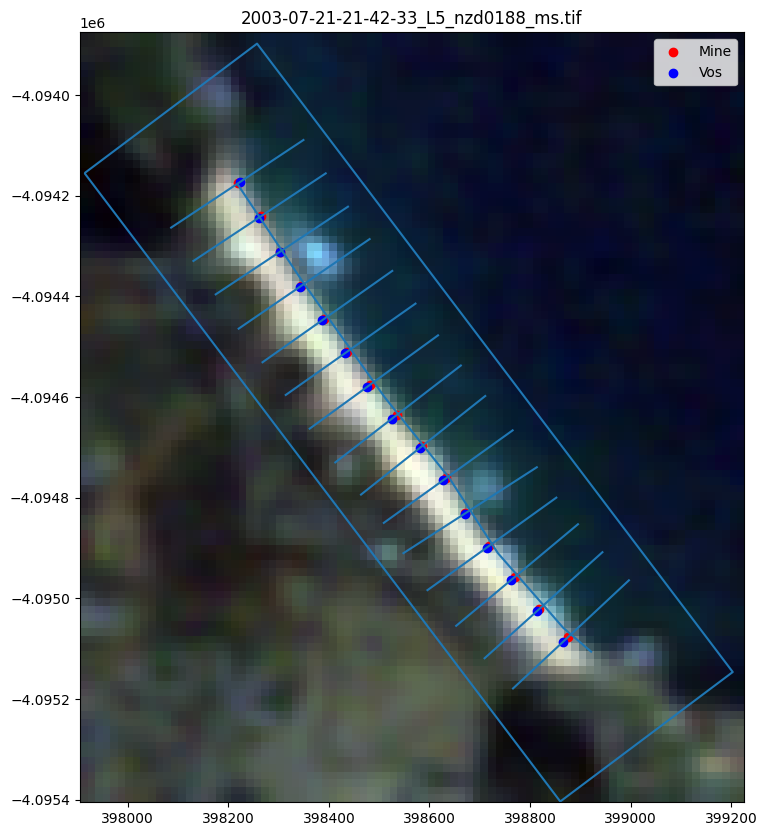

In [75]:
import rasterio as rio
from rasterio.plot import show
src = rio.open("data/nzd0188/L5/ms/2003-07-21-21-42-33_L5_nzd0188_ms.tif")
print(src.meta)
fig, ax = plt.subplots(figsize=(10,10))
# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
print(src.read().shape)
ax = show(src.read()[[2,1,0],:,:], extent=extent, ax=ax, adjust=True)
transects_gdf.to_crs(src.crs).plot(ax=ax)
gpd.GeoSeries([shorelines.geometry[sitename], poly.geometry[sitename].exterior], crs=shorelines.crs).to_crs(src.crs).plot(ax=ax)
my_intersect_points.to_crs(src.crs).plot(ax=ax, color="red", label="Mine")
vos_intersect_points.to_crs(src.crs).plot(ax=ax, color="blue", label="Vos")
plt.legend()
plt.title("2003-07-21-21-42-33_L5_nzd0188_ms.tif")
plt.show()

In [48]:
sitename = "nzd0202"
df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)
vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos.drop(columns="Unnamed: 0", inplace=True)
vos.set_index("dates", inplace=True)
vos.index = pd.to_datetime(vos.index)

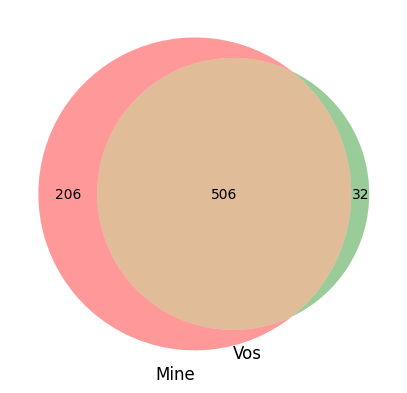

In [49]:
venn2([set(df.index), set(vos.index)], set_labels=('Mine', 'Vos'))
plt.show()

In [90]:
(df.drop(columns="satname") - vos).mean().describe()

count    15.000000
mean      3.160080
std       2.850384
min      -4.434607
25%       2.237699
50%       3.454840
75%       4.380313
max       8.106336
dtype: float64

In [79]:
df = pd.DataFrame({"filename": sorted(glob("data/*/transect_time_series.csv"))})
df["sitename"] = df.filename.str.split("/").str[1]
df

,filename,sitename
0,data/nzd0001/transect_time_series.csv,nzd0001
1,data/nzd0002/transect_time_series.csv,nzd0002
2,data/nzd0003/transect_time_series.csv,nzd0003
3,data/nzd0004/transect_time_series.csv,nzd0004
4,data/nzd0005/transect_time_series.csv,nzd0005
...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557
556,data/nzd0558/transect_time_series.csv,nzd0558
557,data/nzd0559/transect_time_series.csv,nzd0559
558,data/nzd0560/transect_time_series.csv,nzd0560


In [80]:
df["start"] = df.filename.apply(lambda f: pd.read_csv(f).dates.min())
df["end"] = df.filename.apply(lambda f: pd.read_csv(f).dates.max())
df

,filename,sitename,start,end
0,data/nzd0001/transect_time_series.csv,nzd0001,1999-08-17 22:10:26+00:00,2024-08-13 22:17:14+00:00
1,data/nzd0002/transect_time_series.csv,nzd0002,1999-10-04 22:10:38+00:00,2024-08-05 22:17:06+00:00
2,data/nzd0003/transect_time_series.csv,nzd0003,1999-08-17 22:10:26+00:00,2024-08-13 22:17:14+00:00
3,data/nzd0004/transect_time_series.csv,nzd0004,1999-10-04 22:10:38+00:00,2024-08-21 22:17:19+00:00
4,data/nzd0005/transect_time_series.csv,nzd0005,1999-08-17 22:10:26+00:00,2024-08-21 22:17:19+00:00
...,...,...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557,1999-08-17 22:13:37+00:00,2024-08-13 22:20:26+00:00
556,data/nzd0558/transect_time_series.csv,nzd0558,1999-10-04 22:14:13+00:00,2024-08-12 22:26:33+00:00
557,data/nzd0559/transect_time_series.csv,nzd0559,1999-07-16 22:13:35+00:00,2024-08-13 22:20:26+00:00
558,data/nzd0560/transect_time_series.csv,nzd0560,1999-08-17 22:13:37+00:00,2024-08-13 22:20:26+00:00


In [81]:
all_dates = []
for f in df.filename:
  all_dates.extend(pd.read_csv(f).dates)
len(all_dates)

249550

In [82]:
all_dates = pd.to_datetime(all_dates).to_series()
all_dates

1999-08-17 22:10:26+00:00   1999-08-17 22:10:26+00:00
1999-10-04 22:10:38+00:00   1999-10-04 22:10:38+00:00
2000-04-29 22:09:53+00:00   2000-04-29 22:09:53+00:00
2000-06-16 22:09:26+00:00   2000-06-16 22:09:26+00:00
2000-08-03 22:08:44+00:00   2000-08-03 22:08:44+00:00
                                       ...           
2024-06-09 22:26:41+00:00   2024-06-09 22:26:41+00:00
2024-06-17 22:26:08+00:00   2024-06-17 22:26:08+00:00
2024-06-18 22:20:19+00:00   2024-06-18 22:20:19+00:00
2024-07-12 22:20:36+00:00   2024-07-12 22:20:36+00:00
2024-07-20 22:20:14+00:00   2024-07-20 22:20:14+00:00
Length: 249550, dtype: datetime64[ns, UTC]

In [83]:
all_dates.groupby(all_dates.dt.year).count().plot.bar(figsize=(10,10), title="Landsat acquisition by year")

<Axes: title={'center': 'Landsat acquisition by year'}>

In [84]:
df.end = pd.to_datetime(df.end)
df.groupby(df.end.dt.date).end.count().plot(kind="bar")

<Axes: title={'center': 'Landsat acquisition by year'}, xlabel='end'>

In [100]:
def get_vos_diff(sitename):
    df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
    df.drop(columns="Unnamed: 0", inplace=True, errors="ignore")
    df.set_index("dates", inplace=True)
    df.index = pd.to_datetime(df.index)
    vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
    vos.drop(columns="Unnamed: 0", inplace=True)
    vos.set_index("dates", inplace=True)
    vos.index = pd.to_datetime(vos.index)
    return (df - vos).mean(axis=0)

diff_result = df.sitename.apply(get_vos_diff)

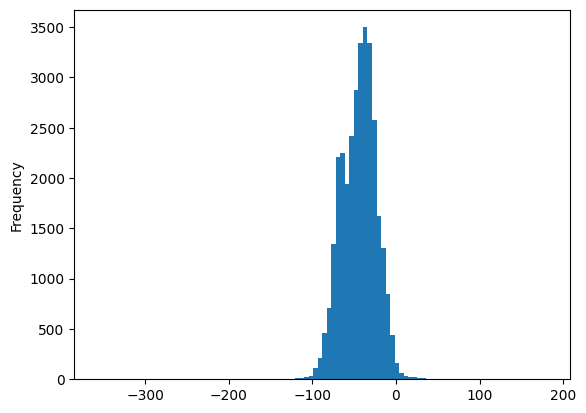

In [101]:
plt.ioff()
diff_result.mean().plot.hist(bins=100)
plt.show()

In [102]:
diff_result.mean().describe()

count    32004.000000
mean       -44.427875
std         21.820595
min       -357.977268
25%        -59.491487
50%        -42.821800
75%        -30.240118
max        181.798978
dtype: float64

In [105]:
transect_diff = diff_result.mean()
transect_diff

nzd0001-0000   -66.197802
nzd0001-0001   -69.208683
nzd0001-0002   -67.092806
nzd0001-0003   -69.196928
nzd0001-0004   -70.683133
                  ...    
nzd0561-0005   -59.727646
nzd0561-0006   -59.685474
nzd0561-0007   -60.503566
nzd0561-0008   -56.776283
nzd0561-0009   -58.180489
Length: 32335, dtype: float64

In [7]:
transects = gpd.read_file("transects.geojson")
transects[transects.site_id.str.startswith("jap")]

,id,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
83793,jap0001-0000,jap0001,127.193599,0.00000,0.000000,NaN,NaN,NaN,0.091176,136.0,80.0,"LINESTRING (150.50341 46.19619, 150.50627 46.1..."
83794,jap0001-0001,jap0001,127.193599,100.00000,0.111198,NaN,NaN,NaN,-0.017135,136.0,83.0,"LINESTRING (150.50286 46.1957, 150.50573 46.1942)"
83795,jap0001-0002,jap0001,127.193599,200.00000,0.222396,NaN,NaN,NaN,-0.108008,136.0,77.0,"LINESTRING (150.50232 46.1952, 150.50518 46.1937)"
83796,jap0001-0003,jap0001,127.193599,300.00000,0.333594,NaN,NaN,NaN,-0.222757,136.0,80.0,"LINESTRING (150.50178 46.19471, 150.50464 46.1..."
83797,jap0001-0004,jap0001,127.193599,400.00000,0.444793,NaN,NaN,NaN,-0.231646,136.0,79.0,"LINESTRING (150.50123 46.19421, 150.5041 46.19..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95045,jap0382-0045,jap0382,137.779167,4499.45724,0.918411,0.110,0.0842,0.1567,-0.689003,316.0,292.0,"LINESTRING (130.88827 30.35596, 130.89068 30.3..."
95046,jap0382-0046,jap0382,131.008372,4599.45724,0.938823,0.130,0.0958,0.2000,-0.639373,316.0,296.0,"LINESTRING (130.88745 30.3553, 130.89016 30.35..."
95047,jap0382-0047,jap0382,123.536055,4699.17487,0.959177,0.115,0.0856,0.1713,-0.423109,316.0,304.0,"LINESTRING (130.88681 30.3545, 130.8898 30.35279)"
95048,jap0382-0048,jap0382,122.855722,4799.17487,0.979588,0.095,0.0736,0.1387,-0.228612,316.0,298.0,"LINESTRING (130.88631 30.35384, 130.88933 30.3..."


count    11257.000000
mean       -84.074368
std         17.780187
min       -114.021744
25%       -101.615119
50%        -80.386440
75%        -69.361963
max        -54.925937
Name: 6669_3857_diff, dtype: float64

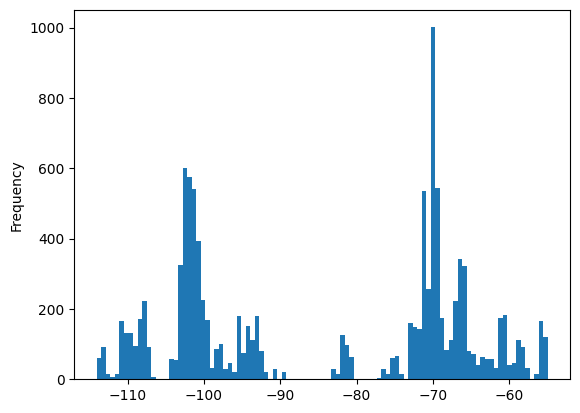

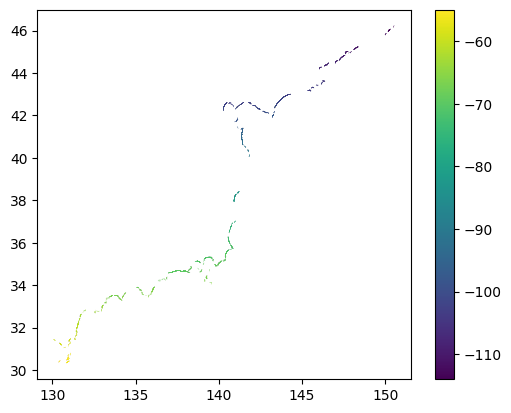

In [8]:
transects = gpd.read_file("transects.geojson")
transects = transects[transects.site_id.str.startswith("jap")]
transects["6669_3857_diff"] = transects.to_crs(6669).length - transects.to_crs(3857).length
display(transects["6669_3857_diff"].describe())
transects["6669_3857_diff"].plot.hist(bins=100)
plt.show()
transects.plot("6669_3857_diff", legend=True)
plt.show()

In [110]:
transects.set_index("id", inplace=True)

In [111]:
transects["vos_diff"] = transect_diff
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry,2193_3857_diff,vos_diff
id,,,,,,,,,,,,,
nzd0001-0000,nzd0001,359.037136,3197.737936,1.000000,0.050,0.0397,0.0679,-0.076912,182.0,145.0,"LINESTRING (172.96364 -34.4273, 172.96358 -34....",-71.341656,-66.197802
nzd0001-0001,nzd0001,359.037136,3097.737936,0.968728,NaN,NaN,NaN,-0.314803,182.0,38.0,"LINESTRING (172.96454 -34.42729, 172.96448 -34...",-71.341610,-69.208683
nzd0001-0002,nzd0001,359.037136,2997.737936,0.937456,0.060,0.0478,0.0776,-0.377247,182.0,168.0,"LINESTRING (172.96544 -34.42728, 172.96537 -34...",-71.341564,-67.092806
nzd0001-0003,nzd0001,359.037136,2897.737936,0.906184,NaN,NaN,NaN,-0.438843,182.0,60.0,"LINESTRING (172.96633 -34.42727, 172.96627 -34...",-71.341518,-69.196928
nzd0001-0004,nzd0001,359.037136,2797.737936,0.874912,0.055,0.0450,0.0664,-0.469478,182.0,173.0,"LINESTRING (172.96723 -34.42726, 172.96717 -34...",-71.341472,-70.683133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0561-0005,nzd0561,141.008990,499.608316,0.555889,0.085,0.0759,0.1026,0.204085,411.0,290.0,"LINESTRING (168.52498 -46.77668, 168.52724 -46...",-125.818034,-59.727646
nzd0561-0006,nzd0561,135.129214,599.517710,0.667053,0.090,0.0775,0.1055,0.196932,411.0,267.0,"LINESTRING (168.52416 -46.77717, 168.5267 -46....",-125.731783,-59.685474
nzd0561-0007,nzd0561,127.431653,698.799788,0.777520,0.080,0.0715,0.0931,0.358584,411.0,257.0,"LINESTRING (168.52342 -46.77775, 168.52627 -46...",-125.619086,-60.503566
